In [33]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import methods
import pymaster as nmt
from importlib import reload

/tmp/ipykernel_23434/3724681249.py:14: RuntimeWarning: invalid value encountered in true_divide
  input_cl /= ell_input*(ell_input+1)/2/np.pi


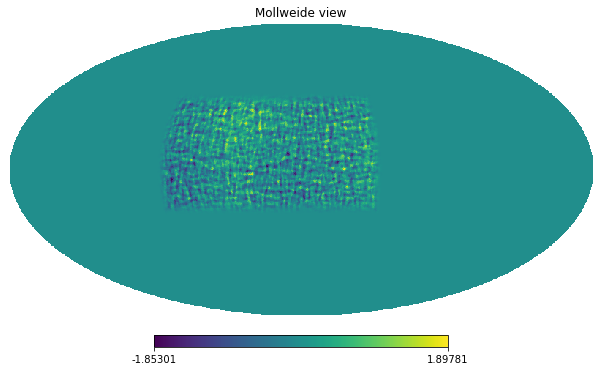

In [34]:
reload(methods)

ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)

nside = 128
lmax = 3*nside-1
npix = 12*nside**2
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
pixels = methods.create_pixels()
bl = methods.get_bl(nside)

input_cl = np.array([TT, EE, BB, TE])
input_cl /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cl: c[0] = 0
input_cl = input_cl[:,:lmax+1]
ell_input = ell_input[:lmax+1]
    
input_cl = np.array([np.zeros(lmax+1), input_cl[1], np.zeros(lmax+1), np.zeros(lmax+1)]) #EE only
# input_cl = np.array([np.zeros(lmax+1), np.zeros(lmax+1), BB, np.zeros(lmax+1)]) #lensed r=0.1

input_map = hp.synfast(input_cl, nside, sigma=sigmab, new=True)

mask = np.zeros(npix)
mask[pixels[0]] = 1
mask_apo = nmt.mask_apodization(mask, 10, apotype="C1")    
hp.mollview(mask_apo * input_map[1])

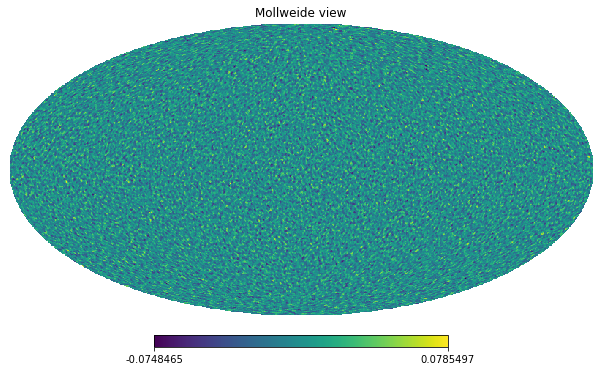

In [35]:
hp.mollview(hp.synfast(1e-10*np.ones(lmax+1)*ell_input*(ell_input+1)/2/np.pi, nside, sigma=sigmab)) #40 nK noise

In [36]:
w = nmt.NmtWorkspace()
w_p = nmt.NmtWorkspace()

b = nmt.NmtBin.from_nside_linear(nside, 16)
ells = b.get_effective_ells()
f = nmt.NmtField(mask_apo, [np.empty(12*nside**2), np.empty(12*nside**2)], beam=bl)
f_p = nmt.NmtField(mask_apo, [np.empty(12*nside**2), np.empty(12*nside**2)], beam=bl, purify_b=True)

w.compute_coupling_matrix(f, f, b)
w_p.compute_coupling_matrix(f_p, f_p, b)

In [37]:
nsims = 10 
Cls = np.zeros((nsims, 4, len(ells)))
Cls_pure = np.zeros((nsims, 4, len(ells)))
anafast = np.zeros((nsims, 3, lmax+1))
anafast_n = np.zeros((nsims, 3, lmax+1))

P_bl = methods.get_P_bl(ells, nside)

for i in range(nsims):
    input_map = hp.synfast(input_cl, nside, sigma=sigmab, new=True)
    f = nmt.NmtField(mask_apo, [input_map[1], input_map[2]])
    f_p = nmt.NmtField(mask_apo, [input_map[1], input_map[2]], purify_b=True)
    Cls[i] = methods.compute_master(f, f, w)
    Cls_pure[i] = methods.compute_master(f_p, f_p, w_p)
    
    patch_map = mask_apo * input_map
    external_map = (1-mask_apo) * input_map
#     noise_map = hp.synfast(1e-8*np.ones(lmax+1), nside, sigma=sigmab)
    noise_map = np.zeros(12*nside**2)
    external_map += noise_map
    anafast[i] = hp.anafast(input_map)[:3] / bl**2
    anafast_n[i] = hp.anafast(external_map + patch_map)[:3] / bl**2

In [38]:
anafast_binned = np.zeros((nsims, 3, len(ells)))
anafast_n_binned = np.zeros((nsims, 3, len(ells)))


for i in range(nsims):
    for j in range(3):
        anafast_binned[i][j] = P_bl @ anafast[i][j]
        anafast_n_binned[i][j] = P_bl @ anafast_n[i][j]


In [39]:
mean = np.mean(Cls, axis=0)
std = np.std(Cls, axis=0)

mean_p = np.mean(Cls_pure, axis=0)
std_p = np.std(Cls_pure, axis=0)

mean_a = np.mean(anafast_binned, axis=0)
std_a = np.std(anafast_binned, axis=0)

mean_n = np.mean(anafast_n_binned, axis=0)
std_n = np.std(anafast_n_binned, axis=0)

[]

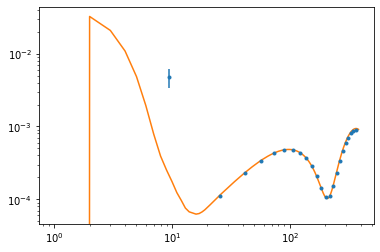

In [44]:
plt.errorbar(ells, mean_a[1], yerr=std_a[1], fmt='.')
plt.plot(ell_input, input_cl[1])
plt.loglog()

(-1e-08, 1e-08)

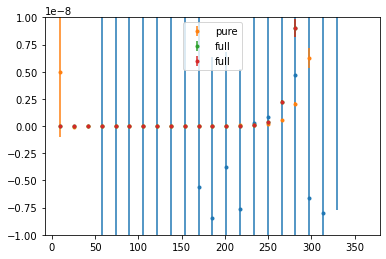

In [41]:
plt.errorbar(ells, mean[3], yerr=std[3], fmt='.')
plt.errorbar(ells, mean_p[3], yerr=std_p[3], fmt='.', label='pure')
plt.errorbar(ells, mean_a[2], yerr=std_a[2], fmt='.', label='full')
plt.errorbar(ells, mean_n[2], yerr=std_n[2], fmt='.', label='full')

plt.legend()
plt.ylim([-1e-8,1e-8])

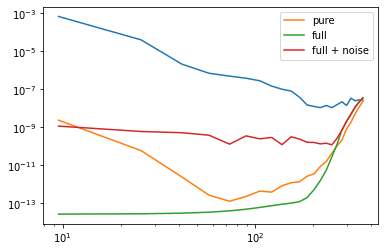

In [32]:
plt.plot(ells, std[3])
plt.plot(ells, std_p[3], label='pure')
plt.plot(ells, std_a[2], label='full')
plt.plot(ells, std_n[2], label='full + noise')

plt.loglog()
plt.legend()